In [78]:
#Import libraries
!pip install tensorflow
!pip install tensorflow-text
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import tqdm

[nltk_data] Downloading package omw-1.4 to C:\Users\Mikas.DESKTOP-
[nltk_data]     G5DRHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
#load the data
df = pd.read_csv(r'C:/Users/Mikas.DESKTOP-G5DRHRA/Desktop/ai-learning/ai-project/spam.csv',sep=',',encoding = "ISO-8859-1")
# df = pd.read_csv(r'C:/Users/Mikas.DESKTOP-G5DRHRA/Desktop/ai-learning/ai-project/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
#data cleaning and fixing to make it easy to use
#select only 2 needed columns of all
#rename the columns for easier and clearer use
df = df[['v1','v2']]
df=df.rename(columns={"v1":"Category","v2":"Message"})
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.groupby('Category').describe()
#data is imbalanced (more ham)
#Problem: a model may learn all the features of the ham emails over spam emails and thus
#always predict all emails as ham (Overfitting)

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [12]:
#Count characters, words, sentences
df['num_characters'] = df['Message'].apply(len)
df['num_words'] = df['Message'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['Message'].apply(lambda x:len(nltk.sent_tokenize(x)))
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.695621,1.970747
std,59.690841,13.742587,1.417778
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,28.000000


In [13]:
#ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4825.000000,4825.000000,4825.000000
mean,71.023627,17.271917,1.808705
std,58.016023,13.988885,1.328227
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [14]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,747.000000,747.000000,747.000000
mean,138.866131,27.891566,3.017403
std,29.183082,6.867007,1.528449
min,13.000000,2.000000,1.000000
25%,132.500000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


In [15]:
df.duplicated().sum()
df = df.drop_duplicates(keep='first')
df.duplicated().sum()
df.shape

(5169, 6)

In [16]:
df.groupby('Category').describe()

target                                    num_characters  \
           count mean  std  min  25%  50%  75%  max          count   
Category                                                             
ham       4516.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         4516.0   
spam       653.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0          653.0   

                      ... num_words        num_sentences                      \
                mean  ...       75%    max         count      mean       std   
Category              ...                                                      
ham        70.459256  ...      22.0  220.0        4516.0  1.799601  1.278465   
spam      137.891271  ...      32.0   46.0         653.0  2.967841  1.483201   

                                    
          min  25%  50%  75%   max  
Category                            
ham       1.0  1.0  1.0  2.0  28.0  
spam      1.0  2.0  3.0  4.0   8.0  

[2 rows x 32 columns]

In [17]:
df.head()

,Category,Message,target,num_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,ham,Ok lar... Joking wif u oni...,0,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2
3,ham,U dun say so early hor... U c already then say...,0,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1


In [11]:
#Preprocessing of Spam Detection Data
#There is text as categorical data and the model doesn't understand them
#Instead of text, assign integer labels (ham = 0, spam = 1)
#Hot-Encoding
# We can cuse one-linear lambda function
#Lambda Fn Syntax = [lambda x:value expression else value]
#df['target'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
#df.sample(5)
df['target'] = df['Category'].apply(lambda x:1 if x=='spam' else 0)
df.sample(5)

,Category,Message,target
3157,ham,Thank u. IT BETTER WORK OUT CAUSE I WILL FEEL ...,0
4169,ham,"Mmmmmm ... I love you,so much, Ahmad ... I can...",0
2532,ham,Yup ok...,0
2912,ham,Kindly send some one to our flat before &lt;D...,0
3636,ham,You know what hook up means right?,0


In [18]:
nltk.download('punkt')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to C:\Users\Mikas.DESKTOP-
[nltk_data]     G5DRHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
def transform_text(Message):
    Message = Message.lower()
    Message = nltk.word_tokenize(Message)
    
    y = []
    for i in Message:
        if i.isalnum():
            y.append(i)
    
    Message = y[:]
    y.clear()
    
    for i in Message:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    Message = y[:]
           
    return " ".join(y)

    df['text'][10]

In [28]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymore tonight k cried enough today'

In [29]:
df['transformed_text'] = df['Message'].apply(transform_text)
df.head()

,Category,Message,target,num_characters,num_words,num_sentences,transformed_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,49,13,1,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah think goes usf lives around though


In [30]:
!pip install wordcloud
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [31]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

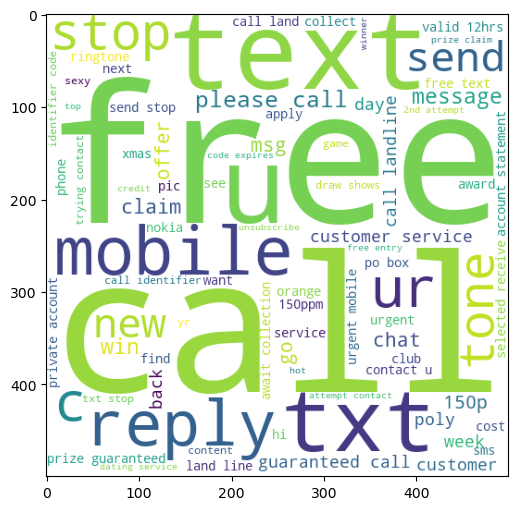

In [32]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [33]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

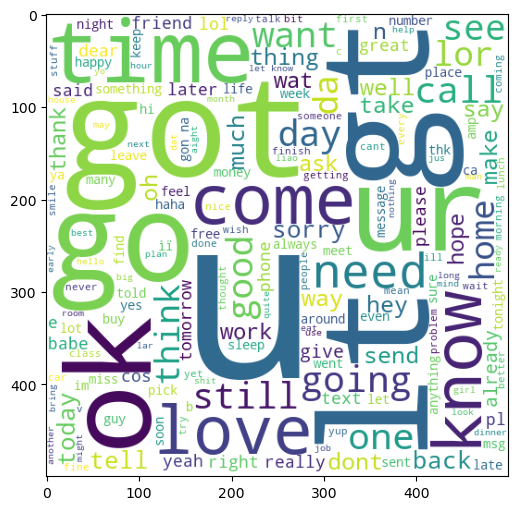

In [34]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [35]:
#Downsampling data - majority class is downsampled to math the minority class
#Pick any 747 samples from the ham class
#1)calculate the percentage of data that needs to be balanced: divide minority (spam) by majority (ham)
print(str(round(653/4516,2))+'%')
#15% of the data needs to be balanced

0.14%


In [36]:
#Perform Train Test Split
# If we feed data in the model, it may bet that model will learn the patterns
#of the data and will always predict the right results, it leads to biasing of the model

#Train Test Split Strategy:
# Training - 80%
# Testing - 20%
# loading train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['transformed_text'], df['target'],stratify = df['target'])
#performed split and set stratify to select almost equal no samples from the datatset

In [37]:
# x_train, y_train - training inputs and labels - Training Set
# x_test, y_test - testing inputs and labels - Testing Set
#End of pre-processing part

In [38]:
# MODEL CREATION

In [39]:
#Downloading Prerequisites
# bert preprocessor and encoder (function pointers)
# can feed inputs and get the processed output and embedding
# better readability of the code
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')


In [40]:
# bert_preprocessor - preprocessor
# bert_encoder - main model (layers - 12, hidden layers - 12, attention - 12)

In [41]:
#Creating model
# use Keras Functional API to build model
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'Dense')(dropout)
#creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [42]:
# text_input: model data shape can be anything, so will pass shape parameters as shape(), its data type as tf.string and name as Inputs
# dropout: for dropout layer, set dropout rate 0.1 of neurons will randomly shut off and passed embedding dictionary pooled_output as an
# --input to this layer i.e. simply passing entire training data embeddings to the dropout layer
# outputs: Sigmod as activation as the problem is binary in nature problem, relu can also be used
# model: inputs will be an array, so used [] in inputs and outputs

In [43]:
# model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [44]:
# 109,482,241 parameters that are from the BERT model and are non-trainable

In [45]:
# COMPILING AND TRAINING MODEL
# Compile model using adam as optimizer and binary_crossentropy as loss function.
# For metrics, will use accuracy, precession, recall and loss
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall')]
# Compiling model
model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = Metrics)

In [46]:
# Training model: fit the model with the training set and let ir tun for 
# 10 epochs
history = model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
122/122 [==============================] - 870s 7s/step - loss: 0.3377 - accuracy: 0.8646 - precision: 0.3118 - recall: 0.0592
Epoch 2/10
122/122 [==============================] - 965s 8s/step - loss: 0.2618 - accuracy: 0.8873 - precision: 0.7912 - recall: 0.1469
Epoch 3/10
122/122 [==============================] - 888s 7s/step - loss: 0.2272 - accuracy: 0.9063 - precision: 0.8396 - recall: 0.3204
Epoch 4/10
122/122 [==============================] - 870s 7s/step - loss: 0.2018 - accuracy: 0.9223 - precision: 0.8765 - recall: 0.4490
Epoch 5/10
122/122 [==============================] - 876s 7s/step - loss: 0.1874 - accuracy: 0.9303 - precision: 0.8929 - recall: 0.5102
Epoch 6/10
122/122 [==============================] - 877s 7s/step - loss: 0.1757 - accuracy: 0.9329 - precision: 0.8808 - recall: 0.5429
Epoch 7/10
122/122 [==============================] - 879s 7s/step - loss: 0.1634 - accuracy: 0.9412 - precision: 0.8946 - recall: 0.6061
Epoch 8/10
122/122 [==============

In [47]:
#90% accurate model, good precession and recalls
# precision - fraction of relevant instances among all retrieved instances
# Recall - sensitivity - fraction of retrieved instances among all relevent instances
# Perfect classifier has precision and recall both equal to 1

In [48]:
# MODEL EVALUATION
# Model's evaluate mehtod feeding it testing data and labels to get a
# rough estimate of how model is performing
model.evaluate(x_test, y_test)

41/41 [==============================] - 289s 7s/step - loss: 0.1511 - accuracy: 0.9598 - precision: 0.9111 - recall: 0.7546


[0.15113793313503265,
 0.9597834348678589,
 0.9111111164093018,
 0.754601240158081]

In [49]:
# Output is similar to training results which may lead to wrong interpretation of the model
# Need for better way to understand how the model is performing
# Will use classification reports and confusion matrices

In [50]:
# Plotting Confusion Matrix and Classification Reports
# sklearn confusion matrix and classification report which takes in actual labels (y_test) 
# and predicted labels (y_pred) and returns an array of numbers which will be plotted
# using seaborn's heatmap and matplotlib


In [51]:
# getting y_pred by predicting over x_text and flattening it
y_pred = model.predict(x_test)
y_pred = y_pred.flatten() #require to be in one-dimensional array, for easy manipulation
# extract predicted probabilities
print(y_pred.round(2))

41/41 [==============================] - 287s 7s/step
[0.06 0.03 0.66 ... 0.04 0.65 0.01]


In [52]:
# extract the predicted class labels
y_pred = np.where(y_pred > 0.5,1,0)
print(y_pred)

[0 0 1 ... 0 1 0]


In [53]:
# importing confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
# creating confusion matrix
cm = confusion_matrix(y_test,y_pred) # or (y_true, y_test.round())
#cm = confusion_matrix(y_test, y_pred.round())
cm

array([[1118,   12],
       [  40,  123]], dtype=int64)

In [54]:
# Predicting x_test to get y_pred(prediction) and flattening it to reshape
# it to one-dimensional vector and feeding it to the
# confusion_matrix function

Text(50.722222222222214, 0.5, 'Actuals')

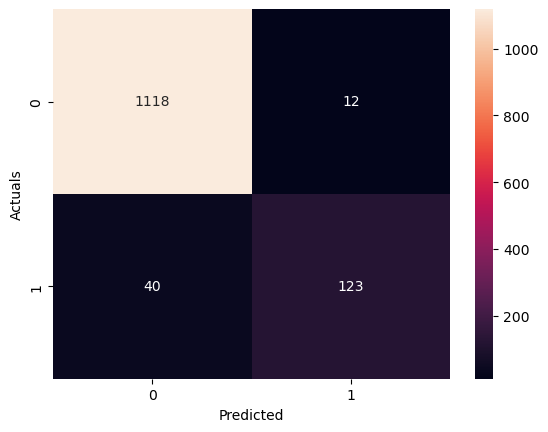

In [55]:
# Plot results with seaborn
import seaborn as sns
# confusion matrix graph
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actuals')

In [56]:
# X axis predicted values
# Y actual values
# VALUES MIGHT CHANGE
# Out of total, 1118 times the mail was ham (0) and the model predicted it right
# For 123 times it was spam and model predicted spam (1)
# 40 times it was spam and model predicted ham
# for 12 times it was ham and model predicted spam

In [57]:
# printing classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1130
           1       0.91      0.75      0.83       163

    accuracy                           0.96      1293
   macro avg       0.94      0.87      0.90      1293
weighted avg       0.96      0.96      0.96      1293



In [58]:
# Model is good, recall and accuracy is good

In [59]:
# Model prediction for spam detection using BERT
# Real world data

In [74]:
predict_text = [# Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest', 
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund', 
                'Your account is temporarily frozen. Please log in to to secure your account ', 
                #ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'Is it ok that I will send you the money for the poker next week? I dont have enough credits in my card for now.']

In [75]:
test_results = model.predict(predict_text)

1/1 [==============================] - 1s 1s/step


In [77]:
output = np.where(test_results > 0.5,'spam','ham')
output #not good result

array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['ham'],
       ['ham']], dtype='<U4')

In [63]:
# What was done with the real - life example
# 1) created a list that contains all the sentences
# 2) predicted the setence category using our model and stored the result ir variable 'test_result'
# 3) created lambda function for filtering values greater than 'as spam' else, not 'spam' using 
# NumPy.where which ideally searches for the value and stores them in the 'outputs'